In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from scipy import stats

import math

from datetime import datetime

import time

In [2]:
# load the data
data = pd.read_csv('btc_ta.csv')

In [3]:
# examine the features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638440 entries, 0 to 2638439
Data columns (total 74 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   time                       int64  
 2   open                       float64
 3   close                      float64
 4   high                       float64
 5   low                        float64
 6   volume                     float64
 7   volume_adi                 float64
 8   volume_obv                 float64
 9   volume_cmf                 float64
 10  volume_fi                  float64
 11  volume_em                  float64
 12  volume_sma_em              float64
 13  volume_vpt                 float64
 14  volume_nvi                 float64
 15  volatility_atr             float64
 16  volatility_bbm             float64
 17  volatility_bbh             float64
 18  volatility_bbl             float64
 19  volatility_bbw             float64
 20  vo

In [4]:
# create the target feature
data['nextClosingPrice'] = data['close'].shift(-1)

# drop the rows with 'None' in target column
data = data.dropna(subset=['nextClosingPrice'])
data = data.drop(['trend_psar_down', 'trend_psar_up'], axis=1)

# drop na values from feature extraction
data = data.dropna()

data['time'] = pd.to_datetime(data['time'], unit='ms')

In [5]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

In [6]:
def testModel(df, windowLength, startingIndex, endingIndex, stepSize, modelName):

    # lists to store data, will concat to make result data frame
    rmseList = []
    predList = []
    realList = []
    predTimeList = []
    trainingTimeList = []
    
    # extract feature and test data
    X = df.drop(['Unnamed: 0', 'time', 'nextClosingPrice'], axis=1)
    y = df['nextClosingPrice']

    # rolling window test
    for i in range(startingIndex, endingIndex, stepSize):
        
        # split the data
        X_train, X_test = X[i-windowLength:i], X[i:i+1]
        y_train, y_test = y[i-windowLength:i], y[i]
        
        # start timer
        startTime = time.time()
        
        # create a new model
        if modelName == 'dt':
            model = DecisionTreeRegressor()
        elif modelName == 'xgb':
            model = XGBRegressor()
        elif modelName == 'lgbm':
            model = LGBMRegressor()
        elif modelName == 'lr':
            model = LinearRegression()
        elif modelName == 'ridge':
            model = Ridge(alpha=0.01)
        elif modelName == 'svr':
            model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
            

        # train the model
        model.fit(X_train, y_train)

        # make a prediction
        y_pred = model.predict(X_test)
        
        endTime = time.time()
        
        # record time figures for result data frame
        predTimeList.append(df['time'][i])
        predList.append(y_pred)
        realList.append(y_test)
        trainingTimeList.append(endTime - startTime)
        
        # measure the error of this prediction
        squared_error = (y_test - y_pred) **2
        root_squared_error = math.sqrt(squared_error)
        rmseList.append(root_squared_error)
        
    # result dictionary
    predList = [x[0] for x in predList]
    result_data = pd.DataFrame({'Timestamp': predTimeList,
                                "Real": realList,
                                "Preds": predList,
                                'rmse': rmseList,
                                'timeToTrain': trainingTimeList})
    
    # result plot
    plt.figure(figsize=(12,6))
    plt.plot('Timestamp', 'Real', data=result_data)
    plt.plot('Timestamp', 'Preds', data=result_data)
    plt.legend()
    
    print("")
    print("RMSE mean:{}".format(result_data['rmse'].mean()))
    print("RMSE std:{}".format(result_data['rmse'].std()))
    print("Time to train mean:{}".format(result_data['timeToTrain'].mean()))
    print("Time to train std:{}".format(result_data['timeToTrain'].std()))
    
    return result_data


RMSE mean:31.68847970037002
RMSE std:20.198804711815864
Time to train mean:0.01339546775817871
Time to train std:0.0023639396701128105


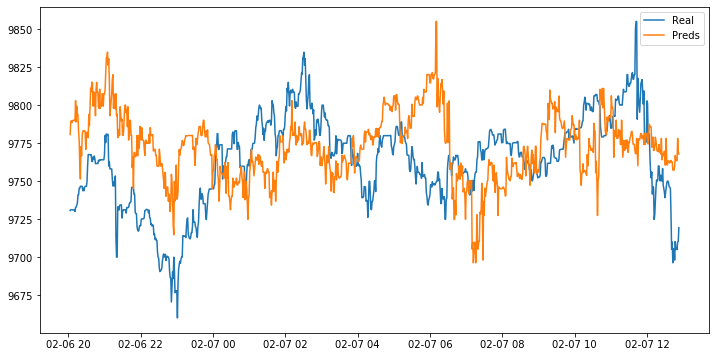

In [18]:
 # test models trained over the previous 360 minutes
dt_results = testModel(data, 360, 2637113, 2638113, 1, 'dt')


RMSE mean:31.15148342851299
RMSE std:19.71802695470762
Time to train mean:0.2129818286895752
Time to train std:0.07426340570957167


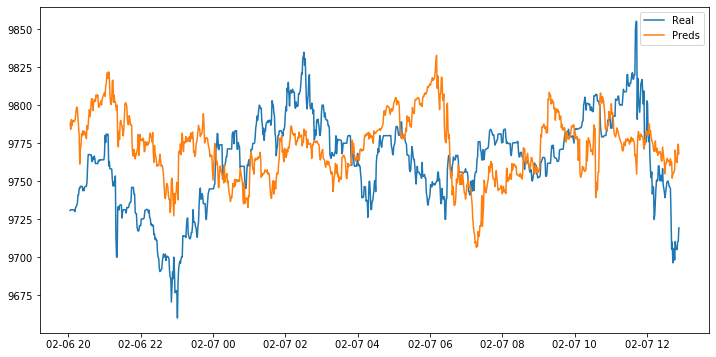

In [19]:
lgbm_results = testModel(data, 360, 2637113, 2638113, 1, 'lgbm')


RMSE mean:35.998021224877135
RMSE std:27.371546890110142
Time to train mean:0.005664616823196411
Time to train std:0.0017472604051499366


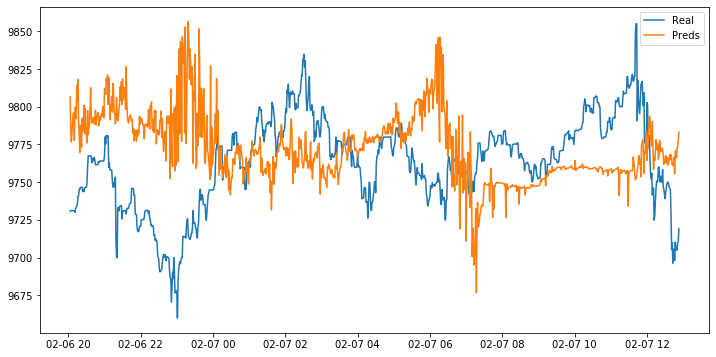

In [20]:
lr_results = testModel(data, 360, 2637113, 2638113, 1, 'lr')

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.09391e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.07924e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.06488e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.05097e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.85024e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.83294e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.8158e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.79827e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\line

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.85925e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.8317e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.80616e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.78537e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\line

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.70508e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.73348e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.76281e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.79162e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.72084e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.71123e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.7055e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.70329e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\line

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.32454e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.29823e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.27073e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.24975e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.17495e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.18706e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.19848e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.21016e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.39353e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.39852e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.40353e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.40864e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.48328e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.48047e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.47772e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.47501e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.78802e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.79542e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.81373e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.83271e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.27251e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.31306e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.3552e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.41787e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\line

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.03704e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.05741e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.07832e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.09067e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.8759e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.89653e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.92272e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.97722e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\line

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.24032e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.01312e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.80207e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.60263e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.99695e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.97863e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.96056e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.94269e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.15447e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.14999e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.14562e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.1415e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\line

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.24315e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.24895e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.25498e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.26107e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.86963e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.89163e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.91424e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.93761e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.79115e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.93359e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.0712e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.21345e-41): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\line

C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.36115e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.38117e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.41742e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.45522e-40): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\vaisu\.conda\envs\MachineLearning-env\lib\site-packages\sklearn\lin


RMSE mean:31.175682878389672
RMSE std:20.21602022631957
Time to train mean:0.004514527559280395
Time to train std:0.0018421709606951503


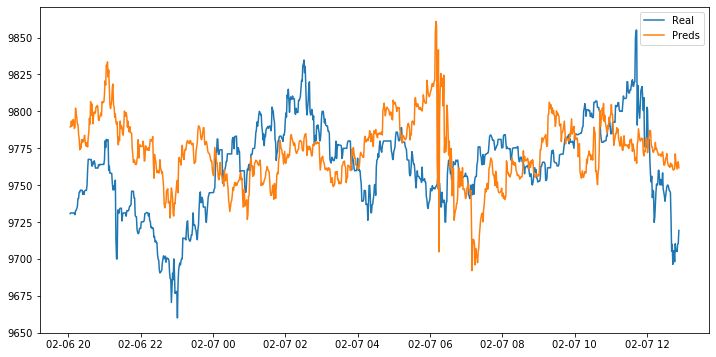

In [21]:
ridge_results = testModel(data, 360, 2637113, 2638113, 1, 'ridge')


RMSE mean:21.120821440245255
RMSE std:17.3827776969121
Time to train mean:0.024433706760406494
Time to train std:0.004422297425763496


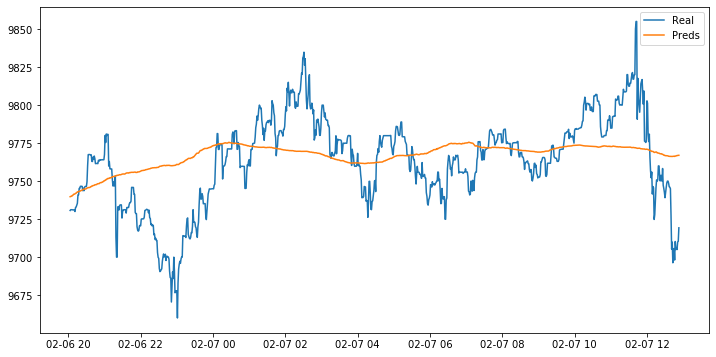

In [22]:
svr_results = testModel(data, 360, 2637113, 2638113, 1, 'svr')


RMSE mean:31.431729506223686
RMSE std:20.046625587795358
Time to train mean:0.3366005823612213
Time to train std:0.07263623116859856


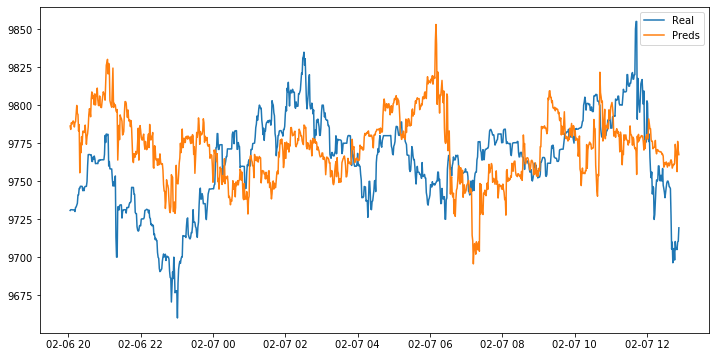

In [23]:
xgb_results = testModel(data, 360, 2637113, 2638113, 1, 'xgb')

In [24]:
pred_results = pd.DataFrame({'Timestamp': dt_results.Timestamp,
                       'Real': dt_results.Real,
                       'Dt_preds': dt_results.Preds,
                       'Lgbm_preds': lgbm_results.Preds,
                       'Xgb_preds': xgb_results.Preds,
                       'Lr_preds': lr_results.Preds,
                       'Ridge_preds': ridge_results.Preds,
                       'Svr_preds': svr_results.Preds})

rmse_results = pd.DataFrame({'Timestamp': dt_results.Timestamp,
                        'Dt_rmse': dt_results.rmse,
                       'Lgbm_rmse': lgbm_results.rmse,
                       'Xgb_rmse': xgb_results.rmse,
                       'Lr_rmse': lr_results.rmse,
                       'Ridge_rmse': ridge_results.rmse,
                       'Svr_rmse': svr_results.rmse})

time_results = pd.DataFrame({'Timestamp': dt_results.Timestamp,
                       'Dt_timeToTrain': dt_results.timeToTrain,
                       'Lgbm_timeToTrain': lgbm_results.timeToTrain,
                       'Xgb_timeToTrain' : xgb_results.timeToTrain,
                       'Lr_timeToTrain': lr_results.timeToTrain,
                       'Ridge_timeToTrain': ridge_results.timeToTrain,
                       'Svr_timeToTrain': svr_results.timeToTrain})

In [25]:
import seaborn as sns

,Real,Dt_preds,Lgbm_preds,Xgb_preds,Lr_preds,Ridge_preds,Svr_preds
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,9763.097037,9772.567601,9772.272126,9772.246490,9772.462947,9772.661403,9766.859606
std,29.581447,21.840120,20.637640,21.433777,22.704526,21.588145,7.747899
min,9660.000000,9696.300000,9706.501936,9695.566406,9676.729739,9692.020175,9739.767108
25%,9745.845568,9758.075000,9757.259659,9756.950439,9757.907560,9759.208308,9762.794565
50%,9765.900000,9773.700000,9773.767056,9773.140137,9769.266102,9772.844114,9769.627743
75%,9781.125000,9784.813251,9784.238045,9784.486572,9785.792431,9784.889612,9772.310118
max,9855.000000,9855.000000,9832.674399,9853.012695,9856.508783,9860.891579,9775.533527


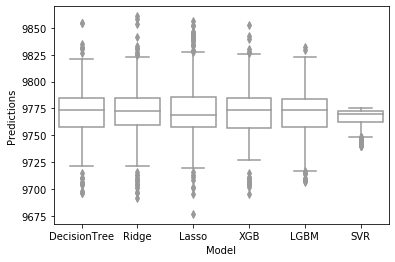

In [26]:
display(pred_results.describe())

# Dataset:
a = pd.DataFrame({ 'Model' : np.repeat('DecisionTree',1000), 'Predictions': pred_results.Dt_preds})
b = pd.DataFrame({ 'Model' : np.repeat('Ridge',1000), 'Predictions': pred_results.Ridge_preds})
c = pd.DataFrame({ 'Model' : np.repeat('Lasso',1000), 'Predictions': pred_results.Lr_preds})
d = pd.DataFrame({ 'Model' : np.repeat('XGB',1000), 'Predictions': pred_results.Xgb_preds})
e = pd.DataFrame({ 'Model' : np.repeat('LGBM',1000), 'Predictions': pred_results.Lgbm_preds})
f = pd.DataFrame({ 'Model' : np.repeat('SVR',1000), 'Predictions': pred_results.Svr_preds})

df=a.append(b).append(c).append(d).append(e).append(f)
 
# Usual boxplot
sns.boxplot(x='Model', y='Predictions', color='w', data=df)
plt.show()

,Dt_rmse,Lgbm_rmse,Xgb_rmse,Lr_rmse,Ridge_rmse,Svr_rmse
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,31.688480,31.151483,31.431730,35.998021,31.175683,21.120821
std,20.198805,19.718027,20.046626,27.371547,20.216020,17.382778
min,0.000000,0.014035,0.041016,0.128479,0.078485,0.060920
25%,15.775000,15.973195,16.334228,14.888461,15.597817,8.328731
50%,28.900000,28.317752,28.241211,29.255242,28.590610,16.450176
75%,45.621463,44.961700,44.739502,50.317911,44.610146,29.090624
max,106.100000,100.410799,104.112305,147.468264,111.991579,100.929240


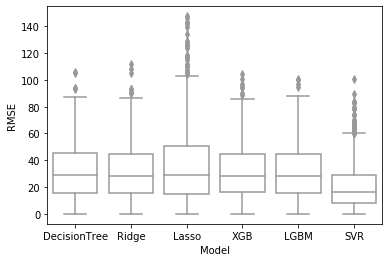

In [27]:
display(rmse_results.describe())

# Dataset:
a = pd.DataFrame({ 'Model' : np.repeat('DecisionTree',1000), 'RMSE': rmse_results.Dt_rmse})
b = pd.DataFrame({ 'Model' : np.repeat('Ridge',1000), 'RMSE': rmse_results.Ridge_rmse})
c = pd.DataFrame({ 'Model' : np.repeat('Lasso',1000), 'RMSE': rmse_results.Lr_rmse})
d = pd.DataFrame({ 'Model' : np.repeat('XGB',1000), 'RMSE': rmse_results.Xgb_rmse})
e = pd.DataFrame({ 'Model' : np.repeat('LGBM',1000), 'RMSE': rmse_results.Lgbm_rmse})
f = pd.DataFrame({ 'Model' : np.repeat('SVR',1000), 'RMSE': rmse_results.Svr_rmse})

df=a.append(b).append(c).append(d).append(e).append(f)
 
# Usual boxplot
sns.boxplot(x='Model', y='RMSE', color='w', data=df)
plt.show()

,Dt_timeToTrain,Lgbm_timeToTrain,Xgb_timeToTrain,Lr_timeToTrain,Ridge_timeToTrain,Svr_timeToTrain
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.013395,0.212982,0.336601,0.005665,0.004515,0.024434
std,0.002364,0.074263,0.072636,0.001747,0.001842,0.004422
min,0.010940,0.118682,0.207445,0.000000,0.000000,0.013462
25%,0.011968,0.167552,0.277258,0.003991,0.003989,0.021942
50%,0.012957,0.180518,0.312010,0.004989,0.003990,0.022942
75%,0.013960,0.240358,0.384154,0.006513,0.004987,0.026928
max,0.044877,0.618168,0.631228,0.015626,0.016625,0.063626


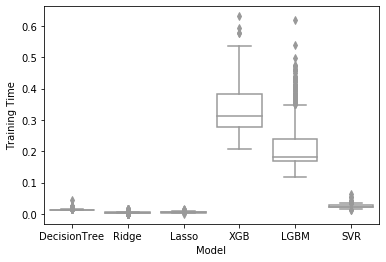

In [28]:
display(time_results.describe())

# Dataset:
a = pd.DataFrame({ 'Model' : np.repeat('DecisionTree',1000), 'Training Time': time_results.Dt_timeToTrain})
b = pd.DataFrame({ 'Model' : np.repeat('Ridge',1000), 'Training Time': time_results.Ridge_timeToTrain})
c = pd.DataFrame({ 'Model' : np.repeat('Lasso',1000), 'Training Time': time_results.Lr_timeToTrain})
d = pd.DataFrame({ 'Model' : np.repeat('XGB',1000), 'Training Time': time_results.Xgb_timeToTrain})
e = pd.DataFrame({ 'Model' : np.repeat('LGBM',1000), 'Training Time': time_results.Lgbm_timeToTrain})
f = pd.DataFrame({ 'Model' : np.repeat('SVR',1000), 'Training Time': time_results.Svr_timeToTrain})

df=a.append(b).append(c).append(d).append(e).append(f)
 
# Usual boxplot
sns.boxplot(x='Model', y='Training Time', color='w', data=df)
plt.show()